<a href="https://colab.research.google.com/github/Ansalnakhan/PROJECT/blob/main/SOH%20PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the necessary packages
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D
from tensorflow.keras.layers import Dropout,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


In [ ]:
#dataset preperation
def load_data(battery):
  mat = loadmat('./dataset/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]




In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


Text(0.5, 1.0, 'Discharge B0005')

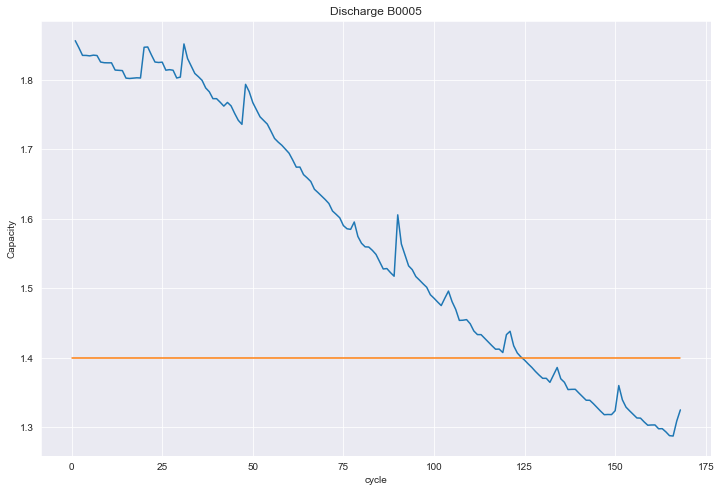

In [ ]:
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [ ]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


In [ ]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


In [ ]:
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

# Lstm

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(train_dataset.shape[1],1)))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 200)            161600    
_________________________________________________________________
dropout (Dropout)            (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               3

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 19s 12ms/step - loss: 0.0036 - root_mean_squared_error: 0.0847
Epoch 2/200
1006/1006 [==============================] - 11s 11ms/step - loss: 9.8436e-04 - root_mean_squared_error: 0.0444- loss: 0.0010 - root_mean_sq
Epoch 3/200
1006/1006 [==============================] - 11s 11ms/step - loss: 7.9034e-04 - root_mean_squared_error: 0.0398:
Epoch 4/200
1006/1006 [==============================] - 12s 12ms/step - loss: 6.6636e-04 - root_mean_squared_error: 0.0365 0s - loss: 6.7356e-04 - root_mean_squared_erro - ETA: 0s - loss: 6.6904e-04 - root_mean_squared_error: 0
Epoch 5/200
1006/1006 [==============================] - 13s 13ms/step - loss: 5.1927e-04 - root_mean_squared_error: 0.0322
Epoch 6/200
1006/1006 [==============================] - 13s 13ms/step - loss: 3.9339e-04 - root_mean_squared_error: 0.0280 10s - loss: 4.2512e - ETA: 9s - loss: 4.3887e-04 - root_mean_squared_e - ETA: 8s - loss: 4.3628e-04 - root_mean_sq - - ETA: 4

1006/1006 [==============================] - 14s 14ms/step - loss: 1.5144e-05 - root_mean_squared_error: 0.0055
Epoch 56/200
1006/1006 [==============================] - 14s 14ms/step - loss: 1.5124e-05 - root_mean_squared_error: 0.0055
Epoch 57/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.5238e-05 - root_mean_squared_error: 0.0055
Epoch 58/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.5055e-05 - root_mean_squared_error: 0.0055
Epoch 59/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.5411e-05 - root_mean_squared_error: 0.0056
Epoch 60/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.4607e-05 - root_mean_squared_error: 0.0054
Epoch 61/200
1006/1006 [==============================] - 11s 11ms/step - loss: 1.5066e-05 - root_mean_squared_error: 0.0055
Epoch 62/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.4784e-05 - root_mean_squared_error: 0.0054
Epoch 63/200


1006/1006 [==============================] - ETA: 0s - loss: 1.3038e-05 - root_mean_squared_error: 0.005 - 12s 11ms/step - loss: 1.3035e-05 - root_mean_squared_error: 0.0051
Epoch 112/200
1006/1006 [==============================] - 11s 11ms/step - loss: 1.3184e-05 - root_mean_squared_error: 0.0051
Epoch 113/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.3345e-05 - root_mean_squared_error: 0.0052
Epoch 114/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.3484e-05 - root_mean_squared_error: 0.0052
Epoch 115/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.3294e-05 - root_mean_squared_error: 0.0052 2s - loss: 1.3307e-
Epoch 116/200
1006/1006 [==============================] - 11s 11ms/step - loss: 1.3176e-05 - root_mean_squared_error: 0.0051
Epoch 117/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.2954e-05 - root_mean_squared_error: 0.0051 0s - loss: 1.2943e-05 - root_mean_squared_error: 0

1006/1006 [==============================] - 12s 12ms/step - loss: 1.2747e-05 - root_mean_squared_error: 0.0050
Epoch 170/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2603e-05 - root_mean_squared_error: 0.0050
Epoch 171/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2627e-05 - root_mean_squared_error: 0.0050
Epoch 172/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2556e-05 - root_mean_squared_error: 0.0050 1s - loss: 1.2539e-05 - root_mean
Epoch 173/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2621e-05 - root_mean_squared_error: 0.0050 2s - loss: 1.2672e-05 - root_mean_squa - ETA: 1s - loss: 1.2617e-05 - root
Epoch 174/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2593e-05 - root_mean_squared_error: 0.0050 0s - loss: 1.2580e-05 - root_mean_squ
Epoch 175/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2695e-05 - root_mean_squared

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data.shape

(50285, 7)

In [ ]:
data = np.reshape(data,(data.shape[0],data.shape[1],1))

In [ ]:

#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  1.001492
1      2  0.994990  0.999116
2      3  0.989185  0.994025
3      4  0.989165  0.994006
4      5  0.982898  0.988137
5      6  0.989467  0.994329
6      7  0.989075  0.993881
7      8  0.967304  0.976016
8      9  0.966997  0.975803
9     10  0.961625  0.972131
Root Mean Square Error:  0.07937985758166202
Mean Absolute Error:  [0.0706104]
R2_score:  0.5866153478400018


Text(0.5, 1.0, 'Discharge B0006')

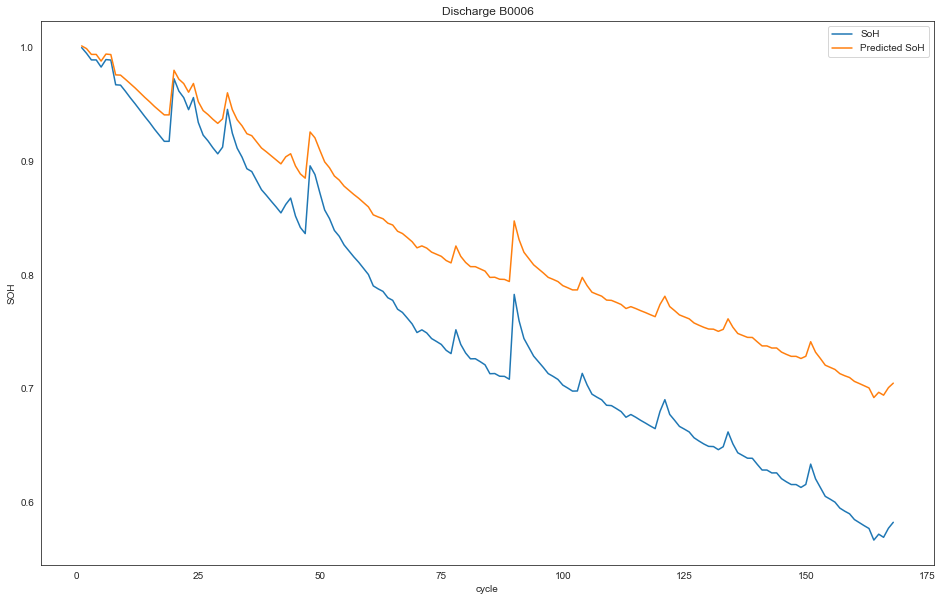

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

#  lstm+conv

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

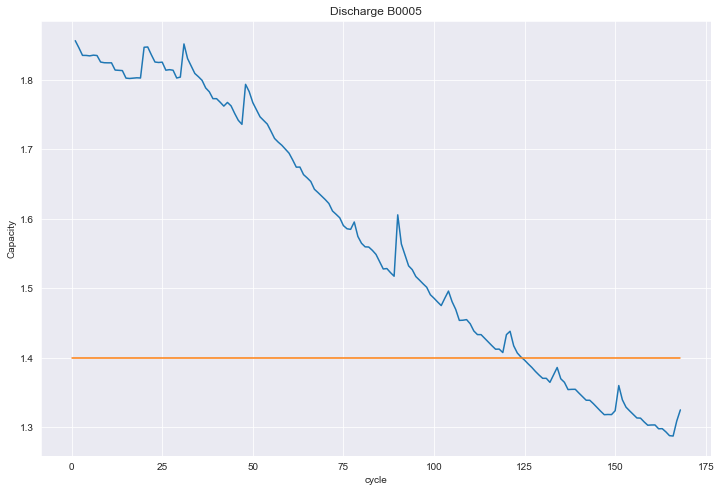

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(train_dataset.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 200)            161600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             19232     
_________________________________________________________________
lstm_9 (LSTM)                (None, 7, 200)            186400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 200)           

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 200)            161600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             19232     
_________________________________________________________________
lstm_9 (LSTM)                (None, 7, 200)            186400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 200)           

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 17s 13ms/step - loss: 0.0036 - root_mean_squared_error: 0.0845
Epoch 2/200
1006/1006 [==============================] - 12s 12ms/step - loss: 8.2983e-04 - root_mean_squared_error: 0.0407 10s - loss: 8.5666e-04 - root_m - ETA: 1s - loss: 8.4451e-04 - root_mea - ETA: 0s - loss: 8.3408e-04 - root_mean_squared_err
Epoch 3/200
1006/1006 [==============================] - 12s 12ms/step - loss: 7.2404e-04 - root_mean_squared_error: 0.0381- ETA: 0s - loss: 7.2823e-04 - root_mean_squared_er
Epoch 4/200
1006/1006 [==============================] - 12s 12ms/step - loss: 5.9801e-04 - root_mean_squared_error: 0.0346 2s -
Epoch 5/200
1006/1006 [==============================] - 13s 13ms/step - loss: 4.8495e-04 - root_mean_squared_error: 0.0311
Epoch 6/200
1006/1006 [==============================] - 13s 13ms/step - loss: 3.6500e-04 - root_mean_squared_error: 0.0270
Epoch 7/200
1006/1006 [==============================] - 13s 13ms/step - loss: 

1006/1006 [==============================] - 12s 12ms/step - loss: 1.5919e-05 - root_mean_squared_error: 0.0056 5s - loss: 1.5778e-05 - root_mean - ETA: 4s - - ETA: 1s - loss: 1.5687e-05 - roo
Epoch 50/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.6199e-05 - root_mean_squared_error: 0.0057
Epoch 51/200
1006/1006 [==============================] - 13s 12ms/step - loss: 1.5868e-05 - root_mean_squared_error: 0.0056 2s - loss: 1.6117e-05 - root_me - ETA: 1s - loss: 1.5987e-05 - root_mean_squared_error:  - ETA: 1s - loss: 1.5946e-05 - root_mean_squared_error:  - ETA: 0s - loss: 1.5901e-05 - root_mean_squared_e
Epoch 52/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.6045e-05 - root_mean_squared_error: 0.0057 0s - loss: 1.5986e-05 - root_mean_squared_error: 
Epoch 53/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.5970e-05 - root_mean_squared_error: 0.0057 0s - loss: 1.5975e-05 - root_mean_squared_error: 0.
Epoch 54

1006/1006 [==============================] - 12s 12ms/step - loss: 1.3916e-05 - root_mean_squared_error: 0.0053 7s - loss: 1.4423e-05 - root_mean_ - ETA: 6s - loss: 1.4
Epoch 98/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.3259e-05 - root_mean_squared_error: 0.0051 9s - loss: 1.3228e-05 - root_mean_squared_error: 0. - ETA: 8s - loss: 1.3190e - E
Epoch 99/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.3380e-05 - root_mean_squared_error: 0.0052 4s - loss: 1.3321e-05 - root_mean_squar - ETA: 3s - loss: 1.3316e-05 - root_mean_squared_error:  - ETA: 2s - l
Epoch 100/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.3382e-05 - root_mean_squared_error: 0.0052
Epoch 101/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.3641e-05 - root_mean_squared_error: 0.0052 11
Epoch 102/200
1006/1006 [==============================] - 14s 14ms/step - loss: 1.3646e-05 - root_mean_squared_error: 0.0052 1s - lo

1006/1006 [==============================] - 12s 12ms/step - loss: 1.2642e-05 - root_mean_squared_error: 0.0050 0s - loss: 1.2630e-05 - root_mean_squared_error: 0.0
Epoch 151/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.2526e-05 - root_mean_squared_error: 0.0050 9s - los - ET
Epoch 152/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.2839e-05 - root_mean_squared_error: 0.0051 11s - loss: 1.1756e-05 - root_mean_squared_err - ETA: 11s - loss: 1.2054e-05 - root_mean_squared_error: 0. - ETA: 11s  
Epoch 153/200
1006/1006 [==============================] - 12s 12ms/step - loss: 1.2688e-05 - root_mean_squared_error: 0.0050
Epoch 154/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2890e-05 - root_mean_squared_error: 0.0051
Epoch 155/200
1006/1006 [==============================] - 14s 13ms/step - loss: 1.2409e-05 - root_mean_squared_error: 0.0050 0s - loss: 1.2417e-05 - root_mean_squared_err
Epoch 156/200
1006/1006 [

1006/1006 [==============================] - 14s 14ms/step - loss: 1.2266e-05 - root_mean_squared_error: 0.0050
Epoch 196/200
1006/1006 [==============================] - 14s 14ms/step - loss: 1.2374e-05 - root_mean_squared_error: 0.0050 0s - loss: 1.2374e-05 - root_mean_squared_error: 0.005
Epoch 197/200
1006/1006 [==============================] - 14s 13ms/step - loss: 1.2258e-05 - root_mean_squared_error: 0.0050 10s - loss: - ETA: 8s - lo - ETA: 2s - l
Epoch 198/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2176e-05 - root_mean_squared_error: 0.0049
Epoch 199/200
1006/1006 [==============================] - 13s 13ms/step - loss: 1.2416e-05 - root_mean_squared_error: 0.0050 6s - lo
Epoch 200/200
1006/1006 [==============================] - 14s 14ms/step - loss: 1.2288e-05 - root_mean_squared_error: 0.0050


In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  0.998690
1      2  0.994990  0.996511
2      3  0.989185  0.992138
3      4  0.989165  0.992127
4      5  0.982898  0.987783
5      6  0.989467  0.992436
6      7  0.989075  0.992020
7      8  0.967304  0.976264
8      9  0.966997  0.976069
9     10  0.961625  0.972395
Root Mean Square Error:  0.07896341199780905
Mean Absolute Error:  [0.06995054]
R2_score:  0.590941398361132


Text(0.5, 1.0, 'Discharge B0006')

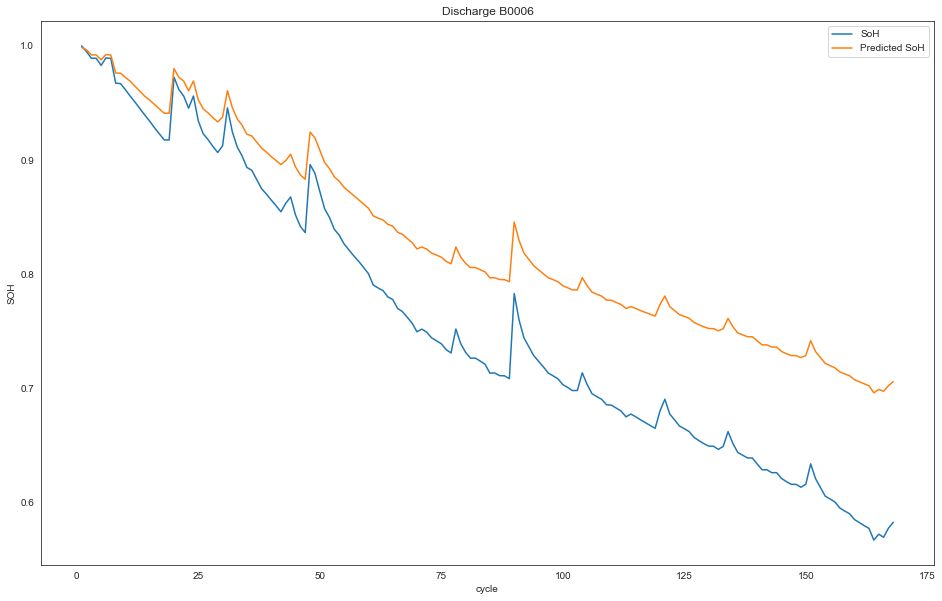

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# lstm+cnn+bilstm

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

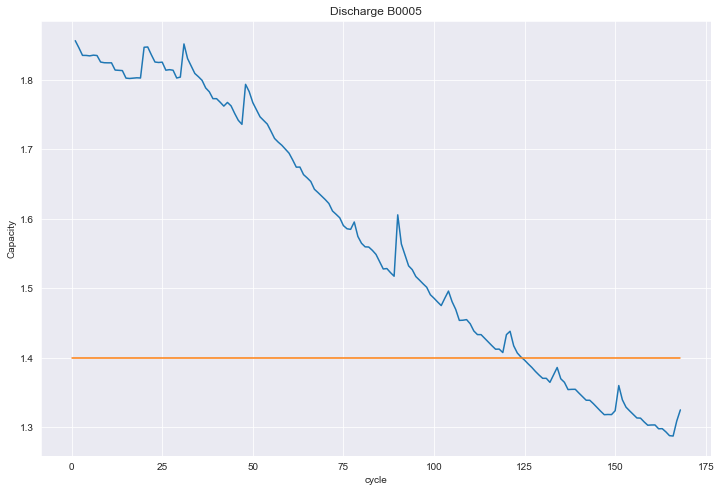

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(train_dataset.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200)))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 200)            161600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 32)             19232     
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 400)            372800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 400)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 400)            961600    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 400)           

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 200)            161600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 32)             19232     
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 400)            372800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 400)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 400)            961600    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 400)           

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 25s 19ms/step - loss: 0.0025 - root_mean_squared_error: 0.0714
Epoch 2/200
1006/1006 [==============================] - 20s 20ms/step - loss: 4.8756e-04 - root_mean_squared_error: 0.0312
Epoch 3/200
1006/1006 [==============================] - 20s 20ms/step - loss: 4.3480e-04 - root_mean_squared_error: 0.0295 13s - loss - ETA: 12s - loss: 4.5148e-04 - - ETA: 11s - loss: 4.4953e-04 - root_mean_squared - ETA: 11s - loss - ETA: 9s - loss: 4.4612e-04 - - ETA: 0s - loss: 4.3494e-04 - root_mean_squared_error: 0.02
Epoch 4/200
1006/1006 [==============================] - 21s 21ms/step - loss: 3.8299e-04 - root_mean_squared_error: 0.0277
Epoch 5/200
1006/1006 [==============================] - 21s 20ms/step - loss: 3.3785e-04 - root_mean_squared_error: 0.0260
Epoch 6/200
1006/1006 [==============================] - 20s 20ms/step - loss: 2.8337e-04 - root_mean_squared_error: 0.0238 11s - loss: 3. - ETA: 10s - loss: 3.0908e-04 - root_m - E

1006/1006 [==============================] - 21s 21ms/step - loss: 1.3142e-05 - root_mean_squared_error: 0.0051 20s -  - ETA: 17s - loss: 1.3351e-05 - root_me - ETA: 16s - loss: 1.3590e-05 - root_mean_squared - ETA: 16s - loss:  - ETA: 12s -  - ETA: 10s - loss: 1.2 - ETA: 8s - loss: 1.3278e-05 - root_mean_s - ETA: 7s - loss: 1.3215e-05 - root_mean_squared_ - ETA: 6s - loss: 1.3 - ETA: 4s - loss: 1.3274e-05 - root_mean_squared_error: 0.00 - ETA: 4s - loss: 1.3263e-05 - root_mean_squared_error: 0. -
Epoch 29/200
1006/1006 [==============================] - 21s 21ms/step - loss: 1.3117e-05 - root_mean_squared_error: 0.0051 16s - loss: 1.3322e-05 - root_mean_squared_error: 0. - ETA: 16s - loss: 1.33 - ETA: 12s - loss: 1.3418e- - ETA: 11s - loss: 1.3338e-05 - root_mean_squared_e  - ETA: 8s - loss: 1.3147e-05 - root_mean_square - ETA: 7s - loss: 1.3304e-05 - root_m - ETA: 6s - loss: 1.3306e-05 - root_mean_squared_error - ETA: 5s - loss: 1.3298e-05  - ETA: 3s - loss: - ETA: 0s - loss: 1.3139e

1006/1006 [==============================] - 21s 21ms/step - loss: 1.0872e-05 - root_mean_squared_error: 0.0047 20s  - ETA: 18s - loss: 9.7618e-06 - root_mean_squared_error: 0.00 - ETA: 18s - loss:  - ETA: 14s - loss - ETA: 11s - loss: - ETA: 9s - loss:  - ETA: 7s - l
Epoch 50/200
1006/1006 [==============================] - 22s 22ms/step - loss: 1.0426e-05 - root_mean_squared_error: 0.0046 19s - loss: 1.1683e-05 - root_ - ETA: 19s - loss: 1.0682e-05 - root_mean_squared_err - ETA: 19s - loss: 1.0606 - ETA: 18s - loss: 1.0445e-05 - root_mean_squared_error: 0.00 - ETA: 18s - loss: 1. - ETA: 16 - ETA: 13s - loss: 1.06 - ETA: 9s - loss: 1.0503e-05 - root_mean_squared_error: 0.00 - ETA: 9s - loss: 1.0510e-05 - root_mean_squared_error: - ETA: 9s - loss: 1.0603e-05 - root_mean_squared_error:  - ETA: 8s - loss: 1.0606e-05 - root_mean_ - ETA: 7s - loss: 1.0548e-05 - root_mean_squared_error: 0.00 - ETA: 7s - loss: 1.0549e-05 - root_mean_sq - ETA: 6s - - ETA: 2s - loss: 1.0415e-05 - root_mean_squ

1006/1006 [==============================] - 23s 22ms/step - loss: 8.9717e-06 - root_mean_squared_error: 0.0042
Epoch 79/200
1006/1006 [==============================] - 22s 22ms/step - loss: 9.0781e-06 - root_mean_squared_error: 0.0043 15s - loss: 8.7199e-06 - root_mean_squared
Epoch 80/200
1006/1006 [==============================] - 22s 22ms/step - loss: 9.1897e-06 - root_mean_squared_error: 0.0043
Epoch 81/200
1006/1006 [==============================] - 23s 23ms/step - loss: 9.2301e-06 - root_mean_squared_error: 0.0043 3s - loss: 9.1719e-06 - root_mean_squared_error: 0.0 - ETA: 2s - loss: 9.1934e-06 - root_mean_squared_error: 0.0 - ETA: 2s - loss: 9.222
Epoch 82/200
1006/1006 [==============================] - 22s 22ms/step - loss: 8.9119e-06 - root_mean_squared_error: 0.0042
Epoch 83/200
1006/1006 [==============================] - 22s 22ms/step - loss: 8.8503e-06 - root_mean_squared_error: 0.0042 2s - loss: 8.9173e-06 - root_mean_squared_e - ETA: 1s - loss: 8.8829e-06 - root
Epo

1006/1006 [==============================] - 22s 22ms/step - loss: 8.4474e-06 - root_mean_squared_error: 0.0041 17s - loss: 8.5662e-06 - root_mean_squared_error:  - ETA: 17s - loss: 8.5950e-06 - root_mean_squar - ETA: 17s - loss: 8.5875e-06 - root_mean_squared_error:  - ETA: 16s - loss: 8.5525e-06 - root_mean_squared_err - ETA: 16s - loss: 8.5488e-06 - root_mean_squ - ETA: 16s - lo - ETA: 14s - loss: 8.4406e-06 - root_mean_squared_err - ETA: 5s - loss: 8.5221e-06 - - ETA: 3s - 
Epoch 108/200
1006/1006 [==============================] - 21s 21ms/step - loss: 8.4318e-06 - root_mean_squared_error: 0.0041
Epoch 109/200
1006/1006 [==============================] - 20s 20ms/step - loss: 8.2143e-06 - root_mean_squared_error: 0.0041 2s - loss: 8.2663e
Epoch 110/200
1006/1006 [==============================] - 21s 21ms/step - loss: 8.4979e-06 - root_mean_squared_error: 0.0041 7s - loss: 8.5744e-06 - root_mean_squared_error: 0 - ETA: 6s - ETA: 3s - loss: 8.5122e-06 - root_mean_sq - ETA: 2s - los

1006/1006 [==============================] - 22s 22ms/step - loss: 7.6112e-06 - root_mean_squared_error: 0.0039 20s - loss: 8.3795e-06 - roo - ETA: 20s - loss: 8.3130e-06 - ETA: 13s - loss: 7.6057 - ETA: 12s - loss: 7.7509e-06 - root_mean_squared_error: 0. - ETA: 12s - loss: 7.7778 - ETA: 2s - loss: 7.6388e-06 - root_mean_square - ETA: 1s - loss: 7.6314e-06 - root_mean_squared_error: 0. - ETA: 1s - loss: 7.6219e-06 - root_me
Epoch 149/200
1006/1006 [==============================] - 22s 22ms/step - loss: 7.8650e-06 - root_mean_squared_error: 0.0040 21s - loss: 7.3664e-06 - root_mean_squared - ETA: 21s - loss: 7.9521e-06 - root_mean_squared_err - ETA: 16s - loss: 7.9873e-06 - root_mean_squared_error:  - ETA: 16 - ETA: 14s  - ETA: 8s - loss: 7.9746e-06 - root_mean_squared_ - ETA: 8s - loss: 7.9957e-06 - r - ETA: 6s - loss: 7.9758e-06 - r - ETA: 0s - loss: 7.8650e-06 - root_mean_squared_error: 0.004
Epoch 150/200
1006/1006 [==============================] - 22s 22ms/step - loss: 7.7739e-0

1006/1006 [==============================] - 22s 22ms/step - loss: 7.5010e-06 - root_mean_squared_error: 0.0039 8s - loss: 7.4971e-06 - root_mean_squ - ETA: 7s - loss: 7.4922e-06 - root_mean_squared_error: 0.0 - ETA: 7s - loss: 7.4764e-06 - root_mean_squared_error: 0.00 - ETA: 7s - loss: 7.4757e-06 - root_mean_sq - ETA: 2s - loss: 7.4972e-06 
Epoch 183/200
1006/1006 [==============================] - 23s 23ms/step - loss: 7.3801e-06 - root_mean_squared_error: 0.0038 5s - loss: 7.3 - ETA: 2s - loss: 
Epoch 184/200
1006/1006 [==============================] - 24s 24ms/step - loss: 7.3165e-06 - root_mean_squared_error: 0.0038
Epoch 185/200
1006/1006 [==============================] - 23s 22ms/step - loss: 7.3310e-06 - root_mean_squared_error: 0.0038 9s - loss: 7.2330e-06 - ETA: 7s - loss: 7.2811e-06 - root_me - ETA: 5s - loss: 7.2854e-06 - root_mean_squa - ETA: 4s - loss: 7.3653e-06 - root_mean_square - ETA: 3s -
Epoch 186/200
1006/1006 [==============================] - 22s 22ms/step - l

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  0.997102
1      2  0.994990  0.995205
2      3  0.989185  0.990279
3      4  0.989165  0.990253
4      5  0.982898  0.985663
5      6  0.989467  0.990535
6      7  0.989075  0.990175
7      8  0.967304  0.975141
8      9  0.966997  0.974944
9     10  0.961625  0.971530
Root Mean Square Error:  0.07814184451520596
Mean Absolute Error:  [0.0690361]
R2_score:  0.5994091414970624


Text(0.5, 1.0, 'Discharge B0006')

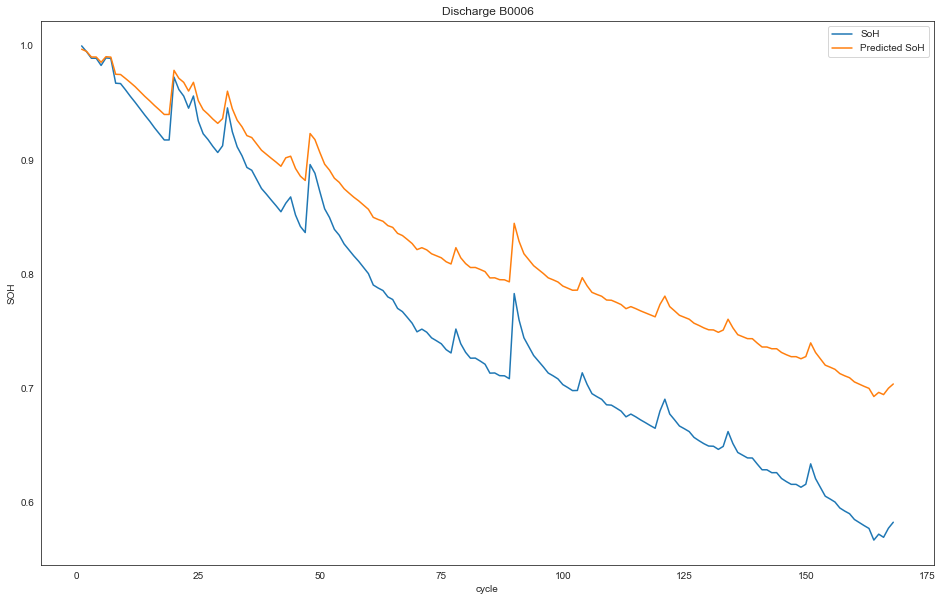

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# Conv +lstm + conv

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

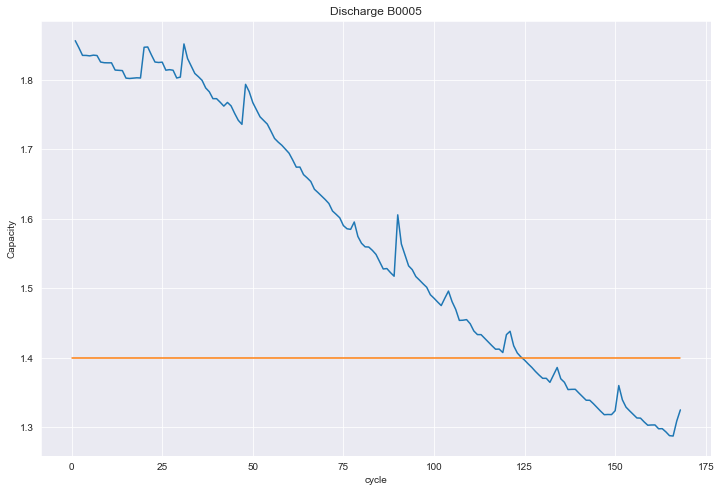

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:

model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(train_dataset.shape[1], train_dataset.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 100)            66000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 32)             9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)               

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 100)            66000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 32)             9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)               

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 7s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0674A: 1s - loss: 0.0033 - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0
Epoch 2/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.0461e-04 - root_mean_squared_error: 0.0202
Epoch 3/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.0393e-04 - root_mean_squared_error: 0.0144
Epoch 4/200
1006/1006 [==============================] - 6s 6ms/step - loss: 4.9128e-05 - root_mean_squared_error: 0.0099
Epoch 5/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.2178e-05 - root_mean_squared_error: 0.0067
Epoch 6/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.3917e-05 - root_mean_squared_error: 0.0053
Epoch 7/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.2193e-05 - root_mean_squared_error: 0.0049
Epoch 8/200
1006/1006 [==============================] - 6s 6ms/step - los

1006/1006 [==============================] - 6s 6ms/step - loss: 3.6172e-06 - root_mean_squared_error: 0.0027A: 1s - loss: 3.7502e-06 - root
Epoch 45/200
1006/1006 [==============================] - 6s 6ms/step - loss: 3.3481e-06 - root_mean_squared_error: 0.0026A: 4s - loss: 3.0684e-06 - root_mean - ETA: 3s - loss: 3.2484 - ETA: 1s - loss: 3.4350e-06 - ro
Epoch 46/200
1006/1006 [==============================] - 6s 6ms/step - loss: 3.4179e-06 - root_mean_squared_error: 0.0026A: 2s - loss: 3.5123e-06 - root_mean_squared_error: 0. - ETA: 2s - loss: 3.4632e-0 - ETA: 0s - loss: 3.4746e-06 - root_mean_squared_error: - ETA: 0s - loss: 3.4372e-06 - root_mean_squared_error: 0. - ETA: 0s - loss: 3.4159e-06 - root_mean_squared_error: 0.00
Epoch 47/200
1006/1006 [==============================] - 6s 6ms/step - loss: 3.3571e-06 - root_mean_squared_error: 0.0026A: 2s - loss: 
Epoch 48/200
1006/1006 [==============================] - ETA: 0s - loss: 2.8994e-06 - root_mean_squared_error: 0.0024 - ET

1006/1006 [==============================] - 6s 6ms/step - loss: 1.5036e-06 - root_mean_squared_error: 0.0017
Epoch 87/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.4789e-06 - root_mean_squared_error: 0.0017A: 0s - loss: 1.4605e-06 - root_mean_squared_error
Epoch 88/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.4243e-06 - root_mean_squared_error: 0.0017A: 3 - ETA: 0s - loss: 1.4259e-06 - root_mean_squared_error: 0.0
Epoch 89/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.5485e-06 - root_mean_squared_error: 0.0018A: 1s - loss: 1.6115e-06 
Epoch 90/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.3797e-06 - root_mean_squared_error: 0.0017A: 4s - loss: 1.3111e-06 - root_mean - 
Epoch 91/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.3601e-06 - root_mean_squared_error: 0.0016A: 2s - loss: 1.3232e-06 - root_mean_squared_er - ETA: 1s - loss: 1.3226e-
Epoch 92/200
1006/1006 

1006/1006 [==============================] - 5s 5ms/step - loss: 9.5394e-07 - root_mean_squared_error: 0.0014A: 1s - loss: 9.6186e-07 - root_mean_sq
Epoch 129/200
1006/1006 [==============================] - 5s 5ms/step - loss: 9.9246e-07 - root_mean_squared_error: 0.0014A: 3 - ETA: 0s - loss: 9.9045e-07 - root_mean_squared_er
Epoch 130/200
1006/1006 [==============================] - 5s 5ms/step - loss: 9.3119e-07 - root_mean_squared_error: 0.0014
Epoch 131/200
1006/1006 [==============================] - 5s 5ms/step - loss: 1.0378e-06 - root_mean_squared_error: 0.0014A: 5s - loss:  - ETA: 2s
Epoch 132/200
1006/1006 [==============================] - 5s 5ms/step - loss: 8.6683e-07 - root_mean_squared_error: 0.0013A: 3s - loss: 7.4968e - ETA: 1s - loss: 8.8270e-07 - root_mean_squared_error: 0.00 - ETA: 1s - loss: 8.7586e-07 - root_mean_squared_error: 0.0 - ETA: 1s - loss: 8.7480e-07 - root_m
Epoch 133/200
1006/1006 [==============================] - 5s 5ms/step - loss: 9.8871e-07 - roo

1006/1006 [==============================] - 6s 6ms/step - loss: 7.7332e-07 - root_mean_squared_error: 0.0012
Epoch 169/200
1006/1006 [==============================] - 6s 6ms/step - loss: 7.5684e-07 - root_mean_squared_error: 0.0012A: 2s - loss: 7.8467e-07 - root_mean_squared_error: 0.001 - ETA: 2s - loss: 7.
Epoch 170/200
1006/1006 [==============================] - 6s 6ms/step - loss: 7.6754e-07 - root_mean_squared_error: 0.0012A: 4s - loss: 9.9924e-07 - root_ - ET
Epoch 171/200
1006/1006 [==============================] - 6s 6ms/step - loss: 7.6355e-07 - root_mean_squared_error: 0.0012
Epoch 172/200
1006/1006 [==============================] - 6s 5ms/step - loss: 8.1522e-07 - root_mean_squared_error: 0.0013A: 3s - loss: 7.8924e-07 - root_mean_squ - ETA: 2s - loss - ETA: 0s - loss: 8.2312e-07 - root_mean_squared_error: 0
Epoch 173/200
1006/1006 [==============================] - 6s 5ms/step - loss: 7.1600e-07 - root_mean_squared_error: 0.0012
Epoch 174/200
1006/1006 [===============

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  0.980372
1      2  0.994990  0.977316
2      3  0.989185  0.973780
3      4  0.989165  0.973771
4      5  0.982898  0.969993
5      6  0.989467  0.973986
6      7  0.989075  0.973756
7      8  0.967304  0.960449
8      9  0.966997  0.960258
9     10  0.961625  0.956991
Root Mean Square Error:  0.0852951518153212
Mean Absolute Error:  [0.07368235]
R2_score:  0.5227099171136511


Text(0.5, 1.0, 'Discharge B0006')

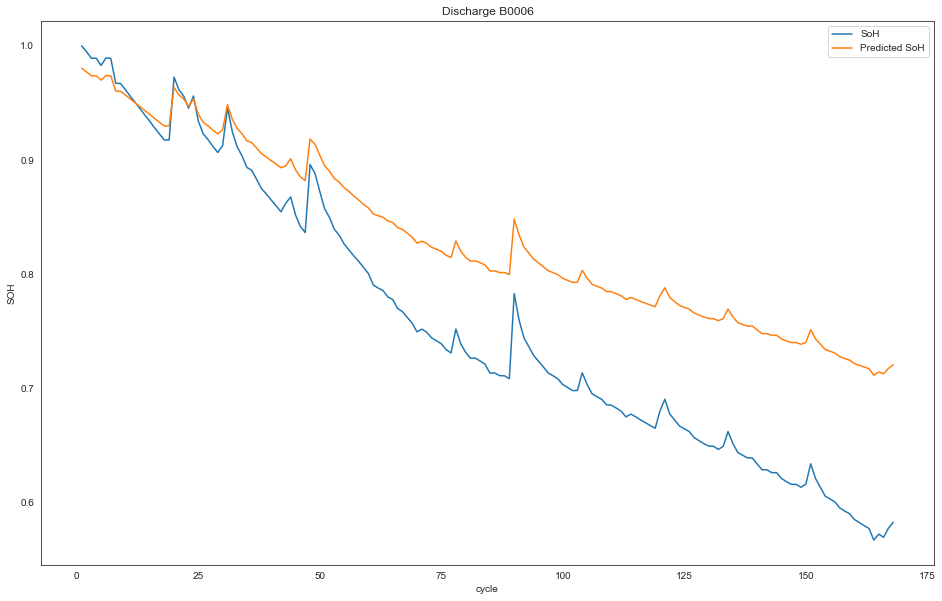

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# Conv +lstm + conv + dnn

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

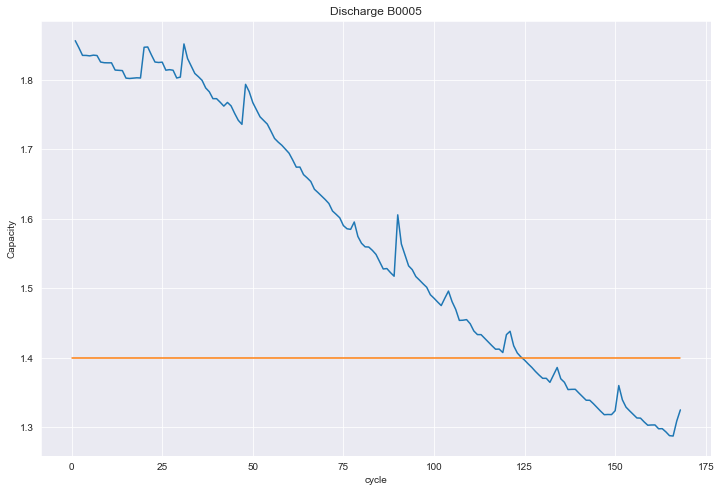

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(train_dataset.shape[1], train_dataset.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3, 100)            66000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3, 32)             9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)               

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3, 100)            66000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3, 32)             9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)               

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 7s 6ms/step - loss: 0.0024 - root_mean_squared_error: 0.0697
Epoch 2/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.1374e-04 - root_mean_squared_error: 0.0151A: 2s - loss: 1.4342e-04 - root_mean_squared_error:  - ETA: 2s - lo
Epoch 3/200
1006/1006 [==============================] - 6s 6ms/step - loss: 3.9932e-05 - root_mean_squared_error: 0.0089A: 2s - loss: 4.6600e-05 - root_mean_squared_erro - ETA: 2s - loss: 4
Epoch 4/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.0554e-05 - root_mean_squared_error: 0.0064
Epoch 5/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.5472e-05 - root_mean_squared_error: 0.0056A: 1s - loss: 1.5925e-05 - ro
Epoch 6/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.4463e-05 - root_mean_squared_error: 0.0054A: 0s - loss: 1.4415e-05 - root_mean_squared_e
Epoch 7/200
1006/1006 [==============================] - 6s 6

1006/1006 [==============================] - 6s 6ms/step - loss: 6.0087e-06 - root_mean_squared_error: 0.0035A: 3s - loss: 5.7045e-06 - root_mean_squared_error: 0.0 - ETA: 3s - loss: 5.9340e-06 - root_mean_squared_error: 0.00 - ETA: 2s - loss: 6. - ETA: 0s - loss: 6.0264e-06 - root_mean_squared
Epoch 44/200
1006/1006 [==============================] - 6s 6ms/step - loss: 5.8355e-06 - root_mean_squared_error: 0.0034A
Epoch 45/200
1006/1006 [==============================] - 6s 6ms/step - loss: 5.6857e-06 - root_mean_squared_error: 0.0034A: 2s - lo
Epoch 46/200
1006/1006 [==============================] - 6s 6ms/step - loss: 5.3483e-06 - root_mean_squared_error: 0.0033A: 0s - loss: 5.4058e-06 - root_mean_squared_
Epoch 47/200
1006/1006 [==============================] - 6s 6ms/step - loss: 5.3047e-06 - root_mean_squared_error: 0.0033A: 5s - loss: 5.4306e-06 - root_mean_squ - ETA: 1s - loss: 5.5029e-06 - ro
Epoch 48/200
1006/1006 [==============================] - 6s 6ms/step - loss: 5.04

1006/1006 [==============================] - 6s 6ms/step - loss: 2.4583e-06 - root_mean_squared_error: 0.0022A: 2s - loss: 2.1956e-06 -  - ETA: 1s - loss: 2.5358e-06 - root_mean
Epoch 83/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.3092e-06 - root_mean_squared_error: 0.0021
Epoch 84/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.3291e-06 - root_mean_squared_error: 0.0022A: 0s - loss: 2.3660e-06 - root_mean_squa
Epoch 85/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.2282e-06 - root_mean_squared_error: 0.0021A: 4s - loss: 2.1693e-06 - roo -  - ETA: 0s - loss: 2.2008e-06 - root_mean_squared_error:
Epoch 86/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.1420e-06 - root_mean_squared_error: 0.0021A: 5s - loss: 1 - ETA: 3s - loss: 2.3302e-06 - root_mean_squar - ETA: 2s - loss
Epoch 87/200
1006/1006 [==============================] - 6s 6ms/step - loss: 2.1233e-06 - root_mean_squared_error: 0.002

1006/1006 [==============================] - 6s 6ms/step - loss: 1.5399e-06 - root_mean_squared_error: 0.0018A:
Epoch 124/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.5128e-06 - root_mean_squared_error: 0.0017A: 2s - loss: 1.7223e-06 - root_mean_squared_error: 0.001 - ETA: 2s
Epoch 125/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.6304e-06 - root_mean_squared_error: 0.0018A: 5s - loss: 1.4723e-06 - root_mean_squared_error: 0.00 - ETA: 4s - loss: 1.4762e-06 - root_mean_square - ETA: 4s - loss: 1.5680e-06 - root_mean_sq - E - ETA: 0s - loss: 1.6387e-06 - root_mean_squared_error: 0.00
Epoch 126/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.3972e-06 - root_mean_squared_error: 0.0017A: 4s - loss: 1.3490e-06 - root_mean_sq - ETA: 3s - loss: 1.4001e-06 - - ETA: 1s - loss: 1.3084e-06 -
Epoch 127/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.4250e-06 - root_mean_squared_error: 0.0017A: 5s - loss

1006/1006 [==============================] - 6s 6ms/step - loss: 1.2376e-06 - root_mean_squared_error: 0.0016A: 4s - loss: 1.1972e-06 - root_mean_squared_ - ETA: 4s - loss: 1.1336e-06 - root_mean_ - ETA: 3s - loss: 1.2046e-06 - root_mean_squar - ETA: 2s - loss: 1.16
Epoch 166/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.2604e-06 - root_mean_squared_error: 0.0016
Epoch 167/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.0792e-06 - root_mean_squared_error: 0.0015A: 0s - loss: 1.0562e-06 - root_mean_square
Epoch 168/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.1394e-06 - root_mean_squared_error: 0.0015A: 1s - loss: 1.1329e-06 - root_
Epoch 169/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.2064e-06 - root_mean_squared_error: 0.0016
Epoch 170/200
1006/1006 [==============================] - 6s 6ms/step - loss: 1.2504e-06 - root_mean_squared_error: 0.0016
Epoch 171/200
1006/1006 [=============

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  0.970738
1      2  0.994990  0.967964
2      3  0.989185  0.964702
3      4  0.989165  0.964686
4      5  0.982898  0.961100
5      6  0.989467  0.964876
6      7  0.989075  0.964658
7      8  0.967304  0.952059
8      9  0.966997  0.951867
9     10  0.961625  0.948682
Root Mean Square Error:  0.08790231616122825
Mean Absolute Error:  [0.07488495]
R2_score:  0.49308591946050795


Text(0.5, 1.0, 'Discharge B0006')

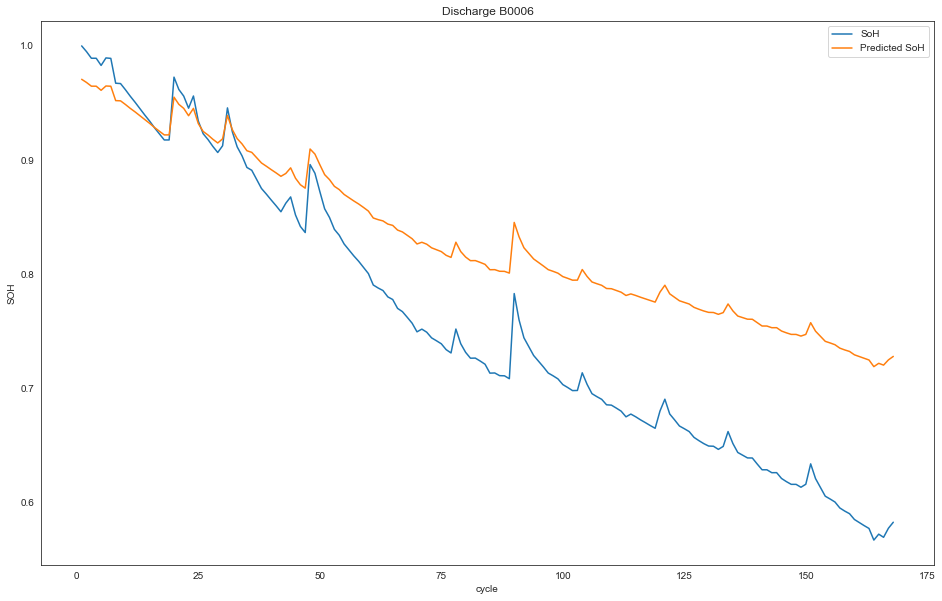

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# CNN_LSTM_DNN

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

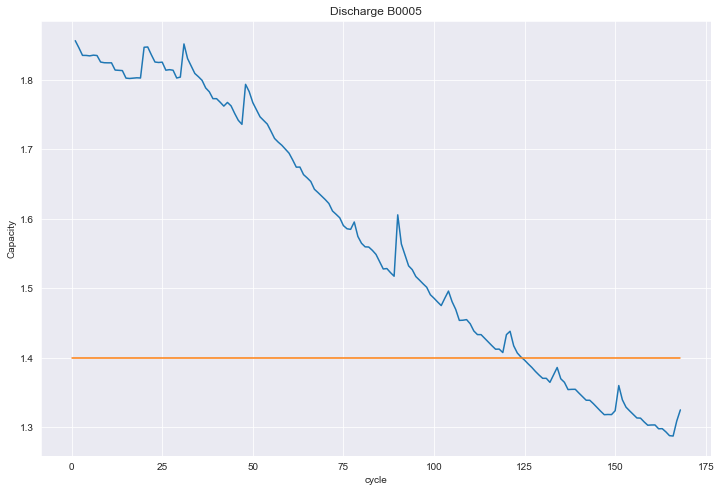

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:
model = Sequential()
#cnn with 64 neurons and kernel size 5 with padding and relu
model.add(Conv1D(64,5,padding="same",input_shape=(train_dataset.shape[1],1)))
#lstm with same return sequences
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(Flatten())
#Fourth part DNN with 16 and 8 with relu activation
model.add(Dense(units=16))
model.add(Dense(units=8))
#final layer
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 7, 64)             384       
_________________________________________________________________
lstm_19 (LSTM)               (None, 7, 32)             12416     
_________________________________________________________________
lstm_20 (LSTM)               (None, 7, 32)             8320      
_________________________________________________________________
flatten_4 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                3600      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 7, 64)             384       
_________________________________________________________________
lstm_19 (LSTM)               (None, 7, 32)             12416     
_________________________________________________________________
lstm_20 (LSTM)               (None, 7, 32)             8320      
_________________________________________________________________
flatten_4 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                3600      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 9s 7ms/step - loss: 0.0027 - root_mean_squared_error: 0.0731
Epoch 2/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.6806e-06 - root_mean_squared_error: 0.0018A: 3s - loss: 2.0309e-06 - root_mean_squared_error: 0. - ETA: 3s - loss: 2.0306 - ETA: 1s - loss: 1.7834e-06 - root_m
Epoch 3/200
1006/1006 [==============================] - 7s 7ms/step - loss: 6.9037e-07 - root_mean_squared_error: 0.0012A: 5s -  - ETA: 2s - loss: 6.7233e-07 - root_mean_squa - ETA: 1s - loss: 7.0840e-07 
Epoch 4/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.5045e-06 - root_mean_squared_error: 0.0017
Epoch 5/200
1006/1006 [==============================] - 7s 7ms/step - loss: 2.9653e-06 - root_mean_squared_error: 0.0024A: 4s - loss: 2.461 - ETA: 2s - loss: 2.5933e-06 - root_ - ETA: 1s - loss: 2.6477e-06 - root_mean_s
Epoch 6/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.5240e-06 - root

1006/1006 [==============================] - 7s 7ms/step - loss: 5.9219e-07 - root_mean_squared_error: 0.0011- ETA: 6s - loss: 4.6317e-07 - root_me - ETA: 4s - loss: 3.4486e-07 - root_mean_squared_error: 8.3049e- - ETA: 4s - loss: 3.3473 - ETA: 2s - loss: 8.200
Epoch 48/200
1006/1006 [==============================] - 7s 7ms/step - loss: 5.0443e-07 - root_mean_squared_error: 0.0010
Epoch 49/200
1006/1006 [==============================] - 7s 7ms/step - loss: 6.3410e-07 - root_mean_squared_error: 0.0011
Epoch 50/200
1006/1006 [==============================] - 7s 7ms/step - loss: 4.3409e-07 - root_mean_squared_error: 9.3176e-04A: 6s - loss: 6.2 - ETA: 4s - loss: 2.9725e-07 - root_mean_squared_error: 7
Epoch 51/200
1006/1006 [==============================] - 7s 7ms/step - loss: 4.6737e-07 - root_mean_squared_error: 9.6681e-04
Epoch 52/200
1006/1006 [==============================] - 7s 7ms/step - loss: 4.0910e-07 - root_mean_squared_error: 9.0455e-04A: 1s - loss: 4.4754e-07 - root_mean_

1006/1006 [==============================] - 7s 7ms/step - loss: 3.1246e-07 - root_mean_squared_error: 7.9052e-04A: 0s - loss: 1.8267e-07 - root_mean_squared_
Epoch 91/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.8406e-07 - root_mean_squared_error: 6.0672e-04A: 3
Epoch 92/200
1006/1006 [==============================] - 7s 7ms/step - loss: 2.2051e-07 - root_mean_squared_error: 6.6409e-04A: 1s - loss: 1.8543e-07 - root_mean
Epoch 93/200
1006/1006 [==============================] - 7s 7ms/step - loss: 2.4095e-07 - root_mean_squared_error: 6.9419e-04
Epoch 94/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.8752e-07 - root_mean_squared_error: 6.1241e-04A: 2s - loss: 2.7
Epoch 95/200
1006/1006 [==============================] - 7s 7ms/step - loss: 2.2452e-07 - root_mean_squared_error: 6.7010e-04A: 4s - loss: 2. - ETA: 2s - loss: 2.6282e-07 - root_mean_squared_error - ETA: 1s - loss: 2.6742e-07 - root_mean_squared_error: 7 - ETA: 1s - loss: 2.

1006/1006 [==============================] - 7s 7ms/step - loss: 2.0234e-07 - root_mean_squared_error: 6.3615e-04A: 6s - loss: 2.08 - ETA: 3s - loss: 1.6410e-07 - root_mean_squared_error: 5.7289e- - ETA: 3s - loss: 1.5949e-07 - root_mean_squared_error:  - ETA: 3 - ETA: 0s - loss: 2.0693e-07 - root_mean_squared_error: 6.4332e
Epoch 141/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.2807e-07 - root_mean_squared_error: 5.0611e-04A: 3s - loss: 1.1766e- - ETA: 0s - loss: 1.4190e-07 - root_mean_squared
Epoch 142/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.7328e-07 - root_mean_squared_error: 5.8870e-04
Epoch 143/200
1006/1006 [==============================] - 7s 7ms/step - loss: 2.1052e-07 - root_mean_squared_error: 6.4887e-04
Epoch 144/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.5547e-07 - root_mean_squared_error: 5.5761e-04
Epoch 145/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.7582e-07 

1006/1006 [==============================] - 7s 7ms/step - loss: 1.3289e-07 - root_mean_squared_error: 5.1554e-04A: 6s - loss: 2.1184e-07 - root_mean_squared_error: - ETA: 5s - loss: 2.0309e-07 - root_mean - ETA: 4s - loss: 1.2220e-07 - root_me - ETA: 2s - loss: 1.8403e-07 - root_mean_squared_error: 6 - ETA: 2s - loss: 1.6772e-07 - - ETA: 0s - loss: 1.3384e-07 - root_mean_squared_error: 5.1737e-
Epoch 188/200
1006/1006 [==============================] - ETA: 0s - loss: 2.1184e-07 - root_mean_squared_error: 6.5091e-04- ETA: 1s - loss: 2.7050e-07 - root_ - 7s 7ms/step - loss: 2.1128e-07 - root_mean_squared_error: 6.5004e-04
Epoch 189/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.3285e-07 - root_mean_squared_error: 5.1546e-04
Epoch 190/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.9919e-07 - root_mean_squared_error: 6.3117e-04A - ETA: 2s - loss: 2.8770e-07 - root_mean_squared_error: 7.5855e - ETA: 2s - loss: 2.7892e-0
Epoch 191/200
1006/10

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  1.000654
1      2  0.994990  0.997078
2      3  0.989185  0.992962
3      4  0.989165  0.992956
4      5  0.982898  0.988525
5      6  0.989467  0.993165
6      7  0.989075  0.992881
7      8  0.967304  0.977465
8      9  0.966997  0.977255
9     10  0.961625  0.973452
Root Mean Square Error:  0.07922738301897067
Mean Absolute Error:  [0.07060536]
R2_score:  0.5882018991557014


Text(0.5, 1.0, 'Discharge B0006')

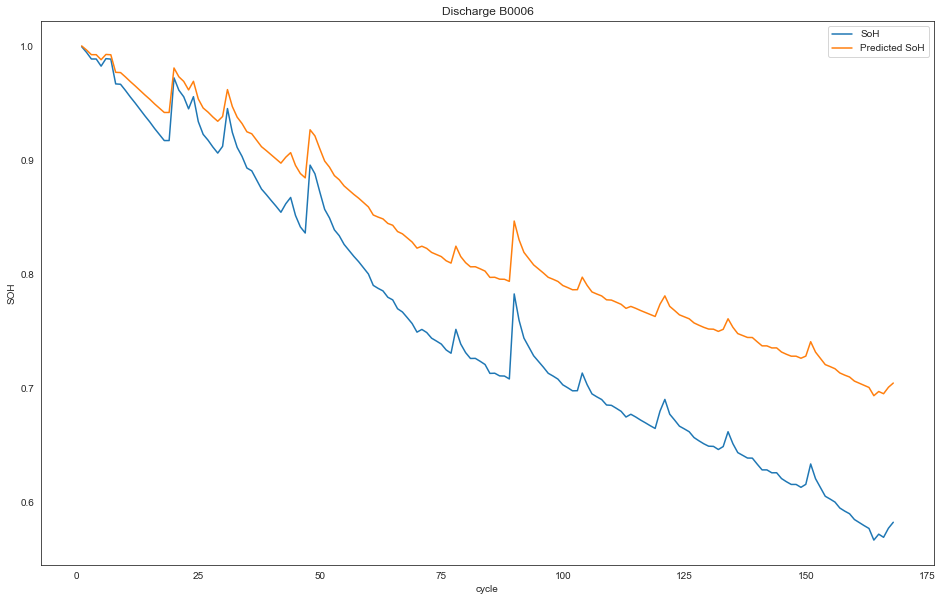

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# cnn+bilstm+dnn

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

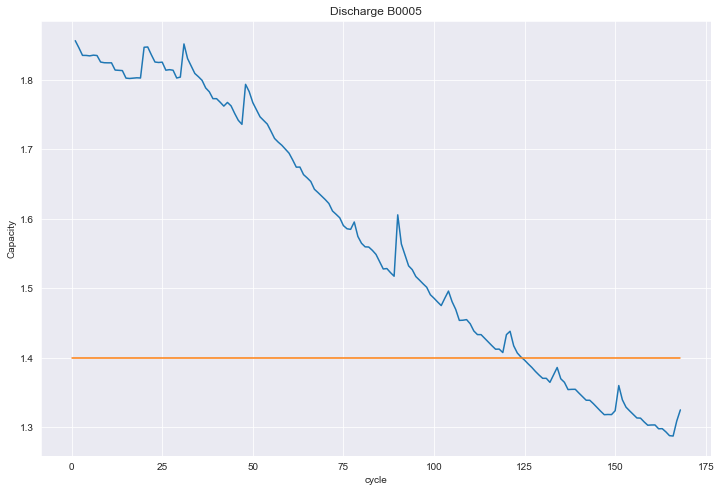

In [ ]:
#Training data
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()
#Training data
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(train_dataset.shape[1], train_dataset.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 3, 200)            132000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 200)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                9616      
_________________________________________________________________
dense_17 (Dense)             (None, 8)               

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 7, 64)             256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 3, 200)            132000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 200)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                9616      
_________________________________________________________________
dense_17 (Dense)             (None, 8)               

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), epochs=200,batch_size=50)

Epoch 1/200
1006/1006 [==============================] - 9s 7ms/step - loss: 0.0019 - root_mean_squared_error: 0.0618
Epoch 2/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.5786e-04 - root_mean_squared_error: 0.0178
Epoch 3/200
1006/1006 [==============================] - 8s 8ms/step - loss: 9.0925e-05 - root_mean_squared_error: 0.0135
Epoch 4/200
1006/1006 [==============================] - 8s 8ms/step - loss: 4.8969e-05 - root_mean_squared_error: 0.0099
Epoch 5/200
1006/1006 [==============================] - 8s 8ms/step - loss: 2.4384e-05 - root_mean_squared_error: 0.0070A: 2s - loss: 2.6630e-05  - ETA: 0s - loss: 2.5260e-05 - root_mean_squared_
Epoch 6/200
1006/1006 [==============================] - 7s 7ms/step - loss: 1.3357e-05 - root_mean_squared_error: 0.0052
Epoch 7/200
1006/1006 [==============================] - 8s 8ms/step - loss: 9.4236e-06 - root_mean_squared_error: 0.0043
Epoch 8/200
1006/1006 [==============================] - 8s 8ms/step - loss

1006/1006 [==============================] - 8s 8ms/step - loss: 4.6897e-06 - root_mean_squared_error: 0.0031
Epoch 62/200
1006/1006 [==============================] - 8s 8ms/step - loss: 4.5440e-06 - root_mean_squared_error: 0.0030
Epoch 63/200
1006/1006 [==============================] - 8s 8ms/step - loss: 4.5459e-06 - root_mean_squared_error: 0.0030
Epoch 64/200
1006/1006 [==============================] - 8s 8ms/step - loss: 4.5990e-06 - root_mean_squared_error: 0.0030A: 0s - loss: 4.6047e-06 - root_mean_squared_error: 0.00
Epoch 65/200
1006/1006 [==============================] - 7s 7ms/step - loss: 4.6187e-06 - root_mean_squared_error: 0.0030
Epoch 66/200
1006/1006 [==============================] - 7s 7ms/step - loss: 4.5144e-06 - root_mean_squared_error: 0.0030
Epoch 67/200
1006/1006 [==============================] - 8s 8ms/step - loss: 4.5400e-06 - root_mean_squared_error: 0.0030A: 1s - loss: 4.5648e-
Epoch 68/200
1006/1006 [==============================] - 8s 8ms/step - lo

1006/1006 [==============================] - ETA: 0s - loss: 4.0395e-06 - root_mean_squared_error: 0.002 - 8s 8ms/step - loss: 4.0379e-06 - root_mean_squared_error: 0.0028
Epoch 121/200
1006/1006 [==============================] - 8s 8ms/step - loss: 3.9780e-06 - root_mean_squared_error: 0.0028A: 0s - loss: 3.9953e-06 - root_mean_squared
Epoch 122/200
1006/1006 [==============================] - 8s 8ms/step - loss: 3.9797e-06 - root_mean_squared_error: 0.0028
Epoch 123/200
1006/1006 [==============================] - 8s 8ms/step - loss: 3.9905e-06 - root_mean_squared_error: 0.0028A: 3s - loss: 3.9186e-06 - root_mean_squared_error: 0.00 - ETA: 
Epoch 124/200
1006/1006 [==============================] - 8s 8ms/step - loss: 3.8584e-06 - root_mean_squared_error: 0.0028
Epoch 125/200
1006/1006 [==============================] - 8s 8ms/step - loss: 3.8924e-06 - root_mean_squared_error: 0.0028A: 1s - loss: 3.8559e-06 - root_m
Epoch 126/200
1006/1006 [==============================] - 8s 8ms/s

1006/1006 [==============================] - 8s 7ms/step - loss: 3.6663e-06 - root_mean_squared_error: 0.0027
Epoch 178/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.6431e-06 - root_mean_squared_error: 0.0027
Epoch 179/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.5744e-06 - root_mean_squared_error: 0.0027
Epoch 180/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.6709e-06 - root_mean_squared_error: 0.0027
Epoch 181/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.6431e-06 - root_mean_squared_error: 0.0027
Epoch 182/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.6019e-06 - root_mean_squared_error: 0.0027
Epoch 183/200
1006/1006 [==============================] - 7s 7ms/step - loss: 3.6938e-06 - root_mean_squared_error: 0.0027A: 2s - loss: 3.6905e-06 - root_mean_squared_error:  - ETA: 1s - loss: 3.7175e-06
Epoch 184/200
1006/1006 [==============================] - 7s 7ms

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
data = sc.fit_transform(dataset_val[attrib])
data = np.reshape(data,(data.shape[0],data.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
#Prediction
soh_pred = model.predict(data)
print(soh_pred.shape)

(50285, 1)


In [ ]:
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

   cycle       SoH    NewSoH
0      1  1.000000  1.003132
1      2  0.994990  0.999674
2      3  0.989185  0.995660
3      4  0.989165  0.995646
4      5  0.982898  0.991302
5      6  0.989467  0.995887
6      7  0.989075  0.995610
7      8  0.967304  0.980448
8      9  0.966997  0.980232
9     10  0.961625  0.976479
Root Mean Square Error:  0.08049006195787131
Mean Absolute Error:  [0.07245214]
R2_score:  0.5749713153400419


Text(0.5, 1.0, 'Discharge B0006')

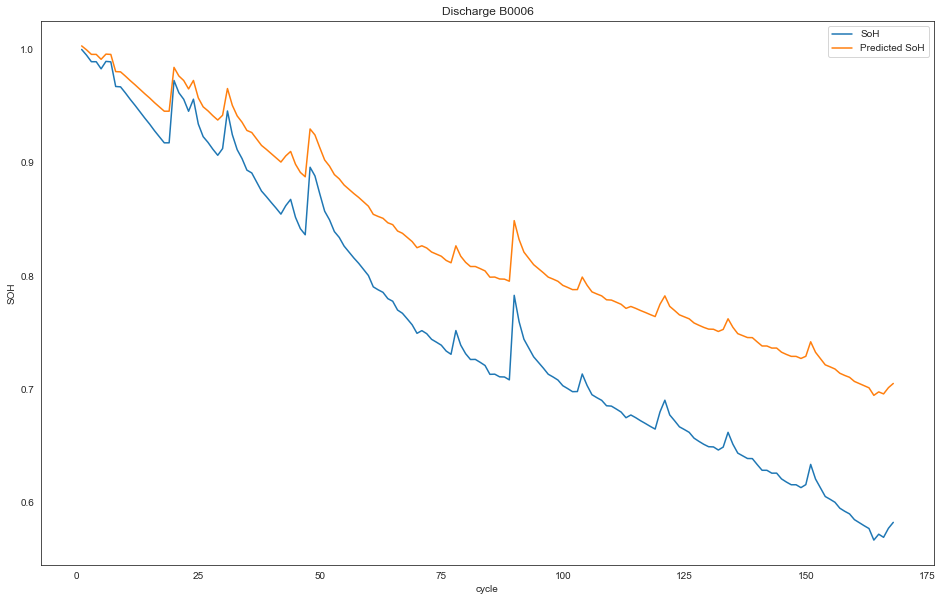

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')